# 

# Automatic analysis of text

> **Update planned: R Tidymodels and tidytext**
>
> At the time of writing this chapter for the published book, `quanteda`
> and `caret` were our packages of choice for machine learning and text
> analysis in R, even though (as noted below) we felt that especially
> supervised text analysis was much better supported in Python than in
> R. We now think that the `tidymodels` and `tidytext` packages are a
> better choice for text analysis, especially for students who have just
> learned to work with the `tidyverse` data wrangling package. For this
> reason, we are planning to rewrite this chapter using those packages.
> See the relevant github issues for
> [tidytext](https://github.com/vanatteveldt/cssbook/issues/5) and
> [tidymodels](https://github.com/vanatteveldt/cssbook/issues/5) for
> more information.

**Abstract.** In this chapter, we discuss different approaches to the
automatic analysis of text; or automated content analysis. We combine
techniques from earlier chapters, such as transforming texts into a
matrix of term frequencies and machine learning. In particular, we
describe three different approaches (dictionary-based analyses,
supervised machine learning, unsupervised machine learning). The chapter
provides guidance on how to conduct such analyses, and also on how to
decide which of the approaches is most suitable for which types of
question.

**Keywords.** dictionary approaches, supervised machine learning,
unsupervised machine learning, topic models, automated content analysis,
sentiment analysis

**Objectives:**

-   Understand different approaches to automatic analysis of text
-   Be able to decide on whether to use a dictionary approach,
    supervised machine learning, or unsupervised machine learning
-   Be able to use these techniques

> **Packages used in this chapter**
>
> This chapter uses the basic text and data handling that were described
> in **?@sec-chap-dtm** (*tidyverse*, *readtext*, and *quanteda* for R,
> *pandas* and *nltk* for Python). For supervised text analysis, we use
> *quanteda.textmodels* in R, and *sklearn* and *keras* in Python. For
> topic models we use *topicmodels* (R) and *gensim* (Python). You can
> install these packages with the code below if needed (see
> **?@sec-installing** for more details):
>
> ## Python code
>
> ``` python
> !pip3 install nltk scikit-learn pandas 
> !pip3 install gensim eli5 keras keras_preprocessing tensorflow
> ```
>
> ## R code
>
> After installing, you need to import (activate) the packages every
> session:
>
> ## Python code
>
> ``` python
> # General packages and dictionary analysis
> import os
> import tarfile
> import bz2
> import urllib.request
> import re
> import pickle
> import nltk
> import joblib
> import requests
> import pandas as pd
> import numpy as np
> from nltk.tokenize import TreebankWordTokenizer
> import matplotlib.pyplot as plt
>
> # Supervised text classification
> from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
> from sklearn.linear_model import LogisticRegression
> from sklearn.naive_bayes import MultinomialNB
> from sklearn.pipeline import make_pipeline, Pipeline
> from sklearn.model_selection import GridSearchCV
> from sklearn import metrics
> import joblib
> # import eli5
> from nltk.sentiment import vader
> from nltk.sentiment.vader import SentimentIntensityAnalyzer
>
> # Deep learning with Keras
> from keras.layers import Dense, Input, GlobalMaxPooling1D, Conv1D, Embedding
> from keras.models import Model
> from tensorflow.keras.optimizers import RMSprop
> from keras_preprocessing.sequence import pad_sequences
> from keras.preprocessing.text import Tokenizer
> from gensim.models.keyedvectors import KeyedVectors
>
> # Topic Modeling
> import gensim
> from gensim import matutils
> from gensim.models.ldamodel import LdaModel
> from gensim.models.coherencemodel import CoherenceModel
> ```
>
> ## R code

In earlier chapters, you learned about both supervised and unsupervised
machine learning as well about dealing with texts. This chapter brings
together these elements and discusses how to combine them to
automatically analyze large corpora of texts. After presenting
guidelines for choosing an appropriate approach in
<a href="#sec-deciding" class="quarto-xref">Section 1.1</a> and
downloading an example dataset in
<a href="#sec-reviewdataset" class="quarto-xref">Section 1.2</a>, we
discuss multiple techniques in detail. We begin with a very simple
top-down approach in
<a href="#sec-dictionary" class="quarto-xref">Section 1.3</a>, in which
we count occurrences of words from an *a priori* defined list of words.
In <a href="#sec-supervised" class="quarto-xref">Section 1.4</a>, we
still use pre-defined categories that we want to code, but let the
machine “learn” the rules of the coding itself. Finally, in
<a href="#sec-unsupervised" class="quarto-xref">Section 1.5</a>, we
employ a bottom-up approach in which we do not use any *a priori*
defined lists or coding schemes, but inductively extract topics from our
data.

## Deciding on the Right Method

When thinking about the computational analysis of texts, it is important
to realize that there is no method that is *the one* to do so. While
there are good choices and bad choices, we also cannot say that one
method is necessarily and always superior to another. Some methods are
more fashionable than others. For instance, there has been a growing
interest in topic models (see
<a href="#sec-unsupervised" class="quarto-xref">Section 1.5</a>) in the
past few years. There are indeed very good applications for such models,
they are also sometimes applied to research questions and/or data where
they make much less sense. As always, the choice of method should follow
the research question and not the other way round. We therefore caution
you about reading
<a href="#sec-chap-text" class="quarto-xref">Section 1</a> selectively
because you want, for instance, to learn about supervised machine
learning or about unsupervised topic models. Instead, you should be
aware of very different approaches to make an informed decision on what
to use when.

@Boumans2016 provide useful guidelines for this. They place automatic
text analysis approaches on a continuum from deductive (or top-down) to
inductive (or bottom-up). At the deductive end of the spectrum, they
place dictionary approaches
(<a href="#sec-dictionary" class="quarto-xref">Section 1.3</a>). Here,
the researcher has strong *a priori* (theoretical) assumptions (for
instance, which topics exist in a news data set; or which words are
positive or negative) and can compile lists of words or rules based on
these assumptions. The computer then only needs to execute these rules.
At the inductive end of the spectrum, in contrast, lie approaches such
as topic models
(<a href="#sec-unsupervised" class="quarto-xref">Section 1.5</a>) where
little or no *a priori* assumptions are made, and where we exploratively
look for patterns in the data. Here, we typically do not know which
topics exist in advance. Supervised approaches
(<a href="#sec-supervised" class="quarto-xref">Section 1.4</a>) can be
placed in between: here, we do define categories *a priori* (we do know
which topics exist, and given an article, we know to which topic it
belongs), but we do not have any set of rules: we do not know which
words to look for or which exact rules to follow. These rules are to be
“learned” by the computer from the data.

Before we get into the details and implementations, let us discuss some
use cases of the three main approaches for the computational analysis of
text: dictionary (or rule-based) approaches, supervised machine
learning, and unsupervised machine learning.

Dictionary approaches excel under three conditions. First, the variable
we want to code is *manifest and concrete* rather than *latent and
abstract*: names of actors, specific physical objects, specific phrases,
etc., rather than feelings, frames, or topics. Second, all synonyms to
be included must be known beforehand. And third, the dictionary entries
must not have multiple meanings. For instance, coding for how often gun
control is mentioned in political speeches fits these criteria. There
are only so many ways to talk about it, and it is rather unlikely that
speeches about other topics contain a phrase like “gun control”.
Similarly, if we want to find references to Angela Merkel, Donald Trump,
or any other well-known politician, we can just directly search for
their names – even though problems arise when people have very common
surnames and are referred to by their surnames only.

Sadly, most interesting concepts are more complex to code. Take a
seemingly straightforward problem: distinguishing whether a news article
is about the economy or not. This is really easy to do for humans: there
may be some edge cases, but in general, people rarely need longer than a
few seconds to grasp whether an article is about the economy rather than
about sports, culture, etc. Yet, many of these articles won’t directly
state that they are about the economy by explicitly using the word
“economy”.

We may think of extending our dictionary not only with `econom.+` (a
regular expression that includes economists, economic, and so on), but
also come up with other words like “stock exchange”, “market”,
“company.” Unfortunately, we will quickly run into a problem that we
also faced when we discussed the precision-recall trade-off in
**?@sec-validation**: the more terms we add to our dictionary, the more
false positives we will get: articles about the geographical space
called “market”, about some celebrity being seen in “company” of someone
else, and so on.

From this example, we can conclude that often (1) it is easy for humans
to decide to which class a text belongs, but (2) it is very hard for
humans to come up with a list of words (or rules) on which their
judgment is based. Such a situation is perfect for applying supervised
machine learning: after all, it won’t take us much time to annotate,
say, 1000 articles based on whether they are about the economy or not
(probably this takes less time than thoroughly fine tuning a list of
words to include or exclude); and the difficult part, deciding on the
exact rules underlying the decision to classify an article as economic
is done by the computer in seconds. Supervised machine learning,
therefore, has replaced dictionary approaches in many areas.

Both dictionary (or rule-based) approaches and supervised machine
learning assume that you know in advance which categories (positive
versus negative; sports versus economy versus politics; …) exist. The
big strength of unsupervised approaches such as topic models is that you
can also apply them without this knowledge. They therefore allow you to
find patterns in data that you did not expect and can generate new
insights. This makes them particularly suitable for explorative research
questions. Using them for confirmatory tests, in contrast, is less
defensible: after all, if we are interested in knowing whether, say,
news site A published more about the economy than news site B, then it
would be a bit weird to pretend not to know that the topic “economy”
exists. Also practically, mapping the resulting topics that the topic
model produces onto such *a priori* existing categories can be
challenging.

Despite all differences, all approaches share one requirement: you need
to “Validate. Validate. Validate” \[@Grimmer2013\]. Though it has been
done in the past, simply applying a dictionary without comparing the
performance to manual coding of the same concepts is not acceptable;
neither is using a supervised machine learning classifier without doing
the same; or blindly trusting a topic model without at least manually
checking whether the scores the model assigns to documents really
capture what the documents are about.

## Obtaining a Review Dataset

For the sections on dictionary and supervised approaches we will use a
dataset of movie reviews from the IMDB database \[@aclimdb\]. This
dataset is published as a compressed set of folders, with separate
folders for the train and test datasets and subfolders for positive and
negative reviews. Lots of other review datasets are available online,
for example for Amazon review data
([jmcauley.ucsd.edu/data/amazon/](https://jmcauley.ucsd.edu/data/amazon/)).

The IMDB dataset we will use is a relatively large file and it requires
bit of processing, so it is smart to *cache* the data rather than
downloading and processing it every time you need it. This is done in
<a href="#exm-reviewdata" class="quarto-xref">Example 1</a>, which also
serves as a nice example of how to download and process files. Both R
and Python follow the same basic pattern. First, we check whether the
cached file exists, and if it does we read the data from that file. For
R, we use the standard *RDS* format, while for Python we use a
compressed *pickle* file. The format of the data is also slightly
different, following the convention for each language: In R we use the
data frame returned by `readtext`, which can read files from a folder or
zip archive and return a data frame containing one text per row. In
Python, we have separate lists for the train and test datasets and for
the full texts and labels: `text_train` are the training texts and
`y_train` are the corresponding labels.

> **Note**
>
> <span class="theorem-title">**Example 1**</span> Downloading and
> caching IMDB review data.
>
> ## Python code
>
> ``` python
> filename = "reviewdata.pickle.bz2"
> if os.path.exists(filename):
>     print(f"Using cached file {filename}")
>     with bz2.BZ2File(filename, "r") as zipfile:
>         data = pickle.load(zipfile)
>     text_train, text_test, y_train, y_test = data
> else:
>     url = "https://cssbook.net/d/aclImdb_v1.tar.gz"
>     print(f"Downloading from {url}")
>     fn, _headers = urllib.request.urlretrieve(url, filename=None)
>     t = tarfile.open(fn, mode="r:gz")
>     text_train, text_test = [], []
>     y_train, y_test = [], []
>     for f in t.getmembers():
>         m = re.match("aclImdb/(\w+)/(pos|neg)/", f.name)
>         if not m:
>             # skip folder names, other categories
>             continue
>         dataset, label = m.groups()
>         text = t.extractfile(f).read().decode("utf-8")
>         if dataset == "train":
>             text_train.append(text)
>             y_train.append(label)
>         elif dataset == "test":
>             text_test.append(text)
>             y_test.append(label)
>     data = text_train, text_test, y_train, y_test
>     print(f"Saving to {filename}")
>     with bz2.BZ2File(filename, "w") as zipfile:
>         pickle.dump(data, zipfile)
> ```
>
> ## R code

If the cached data file does not exist yet, the file is downloaded from
the Internet. In R, we then extract the file and call `readtext` on the
resulting folder. This automatically creates columns for the subfolders,
so in this case for the dataset and label. After this, we remove the
download file and the extracted folder, clean up the `reviewdata`, and
save it to the `reviewdata.rds` file. In Python, we can extract files
from the downloaded file directly, so we do not need to explicitly
extract it. We loop over all files in the archive, and use a regular
expression to select only text files and extract the label and dataset
name (see **?@sec-regular** for more information about regular
expressions). Then, we extract the text from the archive, and add the
text and the label to the appropriate list. Finally, the data is saved
as a compressed pickle file, so the next time we run this cell it does
not need to download the file again.

## Dictionary Approaches to Text Analysis

A straightforward way to automatically analyze text is to compile a list
of terms you are interested in and simply count how often they occur in
each document. For example, if you are interested in finding out whether
mentions of political parties in news articles change over the years,
you only need to compile a list of all party names and write a small
script to count them.

Historically, this is how sentiment analysis was done. Example
<a href="#exm-sentsimple" class="quarto-xref">2</a> shows how to do a
simple sentiment analysis based on a list of positive and negative
words. The logic is straightforward: you count how often each positive
word occurs in a text, you do the same for the negative words, and then
determine which occur more often.

> **Note**
>
> <span class="theorem-title">**Example 2**</span> Different approaches
> to a simple dictionary-based sentiment analysis: counting and summing
> all words using a for-loop over all reviews (Python) versus
> constructing a term-document matrix and looking up the words in there
> (R). Note that both approaches would be possible in either language.
>
> ## Python code
>
> ``` python
> poswords = "https://cssbook.net/d/positive.txt"
> negwords = "https://cssbook.net/d/negative.txt"
> pos = set(requests.get(poswords).text.split("\n"))
> neg = set(requests.get(negwords).text.split("\n"))
> sentimentdict = {word: +1 for word in pos}
> sentimentdict.update({word: -1 for word in neg})
>
> scores = []
> mytokenizer = TreebankWordTokenizer()
> # For speed, we only take the first 100 reviews
> for review in text_train[:100]:
>     words = mytokenizer.tokenize(review)
>     # we look up each word in the sentiment dict
>     # and assign its value (with default 0)
>     scores.append(sum(sentimentdict.get(word, 0) for word in words))
> print(scores)
> ```
>
> ## R code

As you may already realize, there are a lot of downsides to this
approach. Most notably, our bag-of-words approach does not allow us to
account for negation: “not good” will be counted as positive. Relatedly,
we cannot handle modifiers such as “very good”. Also, all words are
either positive or negative, while “great” should be more positive than
“good”. More advanced dictionary-based sentiment analysis packages like
Vader \[@Hutto2014\] or SentiStrength \[@Thelwall2012\] include such
functionalities. Yet, as we will discuss in Section
<a href="#sec-supervised" class="quarto-xref">1.4</a>, also these
off-the-shelf packages perform very poorly in many sentiment analysis
tasks, especially outside of the domains they were developed for.
Dictionary-based sentiment analysis has been shown to be problematic
when analyzing news content (e.g. @Gonzalez-Bailon2015; @Boukes2019).
They are problematic when accuracy at the sentence level is important,
but may be satisfactory with longer texts for comparatively easy tasks
such as movie review classification \[@Reagan2017\], where there is
clear ground truth data and the genre convention implies that the whole
text is evaluative and evaluates one object (the film).

Still, there are many use cases where dictionary approaches work very
well. Because your list of words can contain anything, not just positive
or negative words, dictionary approaches have been used, for instance,
to measure the use of racist words or swearwords in online fora \[e.g.,
@Tulkens2016\]. Dictionary approaches are simple to understand and
straightforward, which can be a good argument for using them when it is
important that the method is no black-box but fully transparent even
without technical knowledge. Especially when the dictionary already
exists or is easy to create, it is also a very cheap method. However,
this is at the expense of their limitation to only performing well when
measuring easy to operationalize concepts. To put it bluntly: it’s great
for measuring the visibility of parties or organizations in the news,
but it’s not good for measuring concepts such as emotions or frames.

What gave dictionary approaches a bit of a bad name is that many
researchers applied them without validating them. This is especially
problematic when a dictionary is applied in a slightly different domain
than that for which it was originally made.

If you want to use a dictionary-based approach, we advise the following
procedure:

-   Construct a dictionary based on theoretical considerations and by
    closely reading a sample of example texts.
    -   Code some articles manually and compare with the automated
        coding.
    -   Improve your dictionary and check again.
    -   Manually code a validation dataset of sufficient size. The
        required size depends a bit on how balanced your data is – if
        one code occurs very infrequently, you will need more data.
    -   Calculate the agreement. You could use standard intercoder
        reliability measures used in manual content analysis, but we
        would also advise you to calculate precision and recall (see
        Section **?@sec-validation**).

Very extensive dictionaries will have a high recall (it becomes
increasingly unlikely that you “miss” a relevant document), but often
suffer from low precision (more documents will contain one of the words
even though they are irrelevant). Vice versa, a very short dictionary
will often be very precise, but miss a lot of documents. It depends on
your research question where the right balance lies, but to
substantially interpret your results, you need to be able to quantify
the performance of your dictionary-based approach.

> **How many documents do you need to calculate agreement with human
> annotators?**
>
> To determine the number of documents one needs to determine the
> agreement between a human and a machine, one can follow the same
> standards that are recommended for traditional manual content
> analysis.
>
> For instance, @Krippendorff2004 provides a convenience table to look
> up the required sample sizes for determining the agreement between two
> human coders (p. 240). @Riffe2019 provide similar suggestions
> (p. 114). In short, the sample size depends on the level of
> statistical significance the researcher deems acceptable as well as on
> the distribution of the data. In an extreme case, if only 5 out of 100
> items are to be coded as $x$, then in a sample of 20 items, such an
> item may not even occur. In order to determine agreement between the
> automated method and a human, we suggest that sample sizes that one
> would also use for the calculation of agreement between human coders
> are used. For specific calculations, we refer to content analysis
> books such as the two referenced here. To give a very rough ballpark
> figure (that shouldn’t replace a careful calculation!), roughly 100 to
> 200 items will cover many scenarios (assuming a small amount of
> reasonably balanced classes).

## Supervised Text Analysis: Automatic Classification and Sentiment Analysis

For many applications, there are good reasons to use the dictionary
approach presented in the previous section. First, it is intuitively
understandable and results can – in principle – even be verified by
hand, which can be an advantage when transparency or communicability is
of high importance. Second, it is very easy to use. But as we have
discussed in
<a href="#sec-deciding" class="quarto-xref">Section 1.1</a>, dictionary
approaches in general perform less well the more abstract, non-manifest,
or complex a concept becomes. In the next section, we will make the case
that topics, but also sentiment, in fact, are quite a complex concepts
that are often hard to capture with dictionaries (or at least, crafting
a custom dictionary would be difficult). For instance, while “positive”
and “negative” seem straightforward categories at first sight, the more
we think about it, the more apparent it becomes how context-dependent it
actually is: in a dataset about the economy and stock market returns,
“increasing” may indicate something positive, in a dataset about
unemployment rates the same word would be something negative. Thus,
machine learning can be a more appropriate technique for such tasks.

### Putting Together a Workflow

With the knowledge we gained in previous chapters, it is not difficult
to set up a supervised machine learning classifier to automatically
determine, for instance, the topic of a news article.

Let us recap the building blocks that we need. In
**?@sec-chap-introsml**, you learned how to use different classifiers,
how to evaluate them, and how to choose the best settings. However, in
these examples, we used numerical data as features; now, we have text.
In **?@sec-chap-dtm**, you learned how to turn text into numerical
features. And that’s all we need to get started!

Typical examples for supervised machine learning in the analysis of
communication include the classification of topics \[e.g.,
@Scharkow2011\], frames \[e.g., @Burscher2014\], user characteristics
such as gender or ideology, or sentiment.

Let us consider the case of sentiment analysis in more detail. Classical
sentiment analysis is done with a dictionary approach: you take a list
of positive words, a list of negative words, and count which occur more
frequently. Additionally, one may attach a weight to each word, such
that “perfect” gets a higher weight than “good”, for instance. An
obvious drawback is that these pure bag-of-words approaches cannot cope
with negation (“not good”) and intensifiers (“very good”), which is why
extensions have been developed that take these (and other features, such
as punctuation) into account \[@Thelwall2012; @Hutto2014;
@DeSmedt2012\].

But while available off-the-shelf packages that implement these extended
dictionary-based methods are very easy to use (in fact, they spit out a
sentiment score with one single line of code), it is questionable how
well they work in practice. After all, “sentiment” is not exactly a
clear, manifest concept for which we can enumerate a list of words. It
has been shown that results obtained with multiple of these packages
correlate very poorly with each other and with human annotations
\[@Boukes2019; @Chan2021\].

Consequently, it has been suggested that it is better to use supervised
machine learning to automatically code the sentiment of texts
\[@Gonzalez-Bailon2015; @vermeer2019seeing\]. However, you may need to
annotate documents from your own dataset: training a classifier on, for
instance, movie reviews and then using it to predict sentiment in
political texts violates the assumption that training set, test set, and
the unlabeled data that are to be classified are (at least in principle
and approximately) drawn from the same population.

To illustrate the workflow, we will use the ACL IMDB dataset, a large
dataset that consists of a training dataset of 25000 movie reviews (of
which 12500 are positive and 12500 are negative) and an equally sized
test dataset \[@aclimdb\]. It can be downloaded at
[ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

These data do not come in one file, but rather in a set of text files
that are sorted in different folders named after the dataset to which
they belong (`test` or `train`) and their label (`pos` and `neg`). This
means that we cannot simply use a pre-defined function to read them, but
we need to think of a way of reading the content into a data structure
that we can use. This data was loaded in
<a href="#exm-reviewdata" class="quarto-xref">Example 1</a> above.

> **Sparse versus dense matrices in Python and R**
>
> In a document-term matrix, you would typically find a lot of zeros:
> most words do *not* appear in any given document. For instance, the
> reviews in the IMDB dataset contain more than 100000 unique words.
> Hence, the matrix has more than 100000 columns. Yet, most reviews only
> consist of a couple of hundred words. As a consequence, more than 99%
> of the cells in the table contain a zero. In a sparse matrix, we do
> not store all these zeros, but only store the values for cells that
> actually contain a value. This drastically reduces the memory needed.
> But even if you have a huge amount of memory, this does not solve the
> issue: in R, the number of cells in a matrix is limited to 2147483647.
> It is therefore impossible to store a matrix with 100000 features and
> 25000 documents as a dense matrix. Unfortunately, many models that you
> can run via *caret* in R will convert your sparse document-term matrix
> to a dense matrix, and hence are effectively only usable for very
> small datasets. An alternative is using the *quanteda* package, which
> does use sparse matrices throughout. However, at the time of writing
> this book, quanteda only provides a very limited number of models. As
> all of these problems do not arise in *scikit-learn*, you may want to
> consider using Python for many text classification tasks.

Let us now train our first classifier. We choose a Naïve Bayes
classifier with a simple count vectorizer
(<a href="#exm-imdbbaseline" class="quarto-xref">Example 3</a>). In the
Python example, pay attention to the fitting of the vectorizer: we fit
on the training data *and* transform the training data with it, but we
only transform the test data *without re-fitting the vectorizer*.
Fitting, here, includes the decision about which words to include (by
definition, words that are not present in the training data are not
included; but we could also choose additional constraints, such as
excluding very rare or very common words), but also assigning an
(internally used) identifier (variable name) to each word. If we fit the
classifier again, these would not be compatible any more. In R, the same
is achieved in a slightly different way: two term-document matrices are
created independently, before they are matched in such a way that only
the features that are present in the training matrix are retained in the
test matrix.

> **Note**
>
> A word that is not present in the training data, but is present in the
> test data, is thus ignored. If you want to use the information such
> out-of-vocabulary words can entail (e.g., they may be synonyms),
> consider using a word embedding approach (see
> **?@sec-wordembeddings**)

We do not necessarily expect this first model to be the best classifier
we can come up with, but it provides us with a reasonable baseline. In
fact, even without any further adjustments, it works reasonably well:
precision is higher for positive reviews and recall is higher for
negative reviews (classifying a positive review as negative happens
twice as much as the reverse), but none of the values is concerningly
low.

> **Note**
>
> <span class="theorem-title">**Example 3**</span> Training a Naïve
> Bayes classifier with simple word counts as features
>
> ## Python code
>
> ``` python
> vectorizer = CountVectorizer(stop_words="english")
> X_train = vectorizer.fit_transform(text_train)
> X_test = vectorizer.transform(text_test)
>
> nb = MultinomialNB()
> nb.fit(X_train, y_train)
>
> y_pred = nb.predict(X_test)
>
> rep = metrics.classification_report(y_test, y_pred)
> print(rep)
> ```
>
> ## R code

### Finding the Best Classifier

Let us start by comparing the two simple classifiers we know (Naïve
Bayes and Logistic Regression (see **?@sec-nb2dnn**) and the two
vectorizers that transform our texts into two numerical representations
that we know: word counts and `tf.idf` scores (see **?@sec-chap-dtm**).

We can also tune some things in the vectorizer, such as filtering out
stopwords, or specifying a minimum number (or proportion) of documents
in which a word needs to occur in order to be included, or the maximum
number (or proportion) of documents in which it is allowed to occur. For
instance, it could make sense to say that a word that occurs in less
than $n=5$ documents is probably a spelling mistake or so unusual that
it just unnecessarily bloats our feature matrix; and on the other hand,
a word that is so common that it occurs in more than 50% of all
documents is so common that it does not help us to distinguish between
different classes.

We can try all of these things out by hand by just re-running the code
from <a href="#exm-imdbbaseline" class="quarto-xref">Example 3</a> and
only changing the line in which the vectorizer is specified and the line
in which the classifier is specified. However, copy-pasting essentially
the same code is generally not a good idea, as it makes your code
unnecessary long and increases the likelihood of errors creeping in when
you, for instance, need to apply the same changes to multiple copies of
the code. A more elegant approach is outlined in
<a href="#exm-basiccomparisons" class="quarto-xref">Example 4</a>: We
define a function that gives us a short summary of only the output we
are interested in, and then use a for-loop to iterate over all
configurations we want to evaluate, fit them and call the function we
defined before. In fact, with 23 lines of code, we manage to compare
four different models, while we already needed 15 lines (in
<a href="#exm-imdbbaseline" class="quarto-xref">Example 3</a>) to
evaluate only one model.

> **Note**
>
> <span class="theorem-title">**Example 4**</span> An example of a
> custom function to give a brief overview of the performance of four
> simple vectorizer-classifier combinations.
>
> ``` python
> def short_classification_report(y_test, y_pred):
>     print("    \tPrecision\tRecall")
>     for label in set(y_pred):
>         pr = metrics.precision_score(y_test, y_pred, pos_label=label)
>         re = metrics.recall_score(y_test, y_pred, pos_label=label)
>         print(f"{label}:\t{pr:0.2f}\t\t{re:0.2f}")
> ```
>
> ``` python
> configs = [
>     ("NB-count", CountVectorizer(min_df=5, max_df=0.5), MultinomialNB()),
>     ("NB-TfIdf", TfidfVectorizer(min_df=5, max_df=0.5), MultinomialNB()),
>     (
>         "LR-Count",
>         CountVectorizer(min_df=5, max_df=0.5),
>         LogisticRegression(solver="liblinear"),
>     ),
>     (
>         "LR-TfIdf",
>         TfidfVectorizer(min_df=5, max_df=0.5),
>         LogisticRegression(solver="liblinear"),
>     ),
> ]
>
> for name, vectorizer, classifier in configs:
>     print(name)
>     X_train = vectorizer.fit_transform(text_train)
>     X_test = vectorizer.transform(text_test)
>     classifier.fit(X_train, y_train)
>     y_pred = classifier.predict(X_test)
>     short_classification_report(y_test, y_pred)
>     print("\n")
> ```

The output of this little example already gives us quite a bit of
insight into how to tackle our specific classification tasks: first, we
see that a $tf\cdot idf$ classifier seems to be slightly but
consistently superior to a count classifier (this is often, but not
always the case). Second, we see that the logistic regression performs
better than the Naïve Bayes classifier (again, this is often, but not
always, the case). In particular, in our case, the logistic regression
improved on the excessive misclassification of positive reviews as
negative, and achieves a very balanced performance.

There may be instances where one nevertheless may want to use a Count
Vectorizer with a Naïve Bayes classifier instead (especially if it is
too computationally expensive to estimate the other model), but for now,
we may settle on the best performing combination, logistic regression
with a `tf.idf` vectorizer. You could also try fitting a Support Vector
Machine instead, but we have little reason to believe that our data
isn’t linearly separable, which means that there is little reason to
believe that the SVM will perform better. Given the good performance we
already achieved, we decide to stick to the logistic regression for now.

We can now go as far as we like, include more models, use
crossvalidation and gridsearch (see **?@sec-crossvalidation**), etc.
However, our workflow now consists of *two* steps: fitting/transforming
our input data using a vectorizer, and fitting a classifier. To make
things easier, in scikit-learn, both steps can be combined into a
so-called pipe.
<a href="#exm-basicpipe" class="quarto-xref">Example 5</a> shows how the
loop in
<a href="#exm-basiccomparisons" class="quarto-xref">Example 4</a> can be
re-written using pipes (the result stays the same).

> **Note**
>
> <span class="theorem-title">**Example 5**</span> Instead of fitting
> vectorizer and classifier separately, they can be combined in a
> pipeline.
>
> ``` python
> for name, vectorizer, classifier in configs:
>     print(name)
>     pipe = make_pipeline(vectorizer, classifier)
>     pipe.fit(text_train, y_train)
>     y_pred = pipe.predict(text_test)
>     short_classification_report(y_test, y_pred)
>     print("\n")
> ```

Such a pipeline lends itself very well to performing a gridsearch.
<a href="#exm-gridsearchlogreg" class="quarto-xref">Example 6</a> gives
you an example. With `LogisticRegression?` and `TfIdfVectorizer?`, we
can get a list of all possible hyperparameters that we may want to tune.
For instance, these could be the minimum and maximum frequency for words
to be included or whether we want to use only unigrams (single words) or
also bigrams (combinations of two words, see **?@sec-ngram**). For the
Logistic Regression, it may be the regularization hyperparameter C,
which applies a penalty for too complex models. We can put all values
for these parameters that we want to consider in a dictionary, with a
descriptive key (i.e., a string with the step of the pipeline followed
by two underscores and the name of the hyperparameter) and a list of all
values we want to consider as the corresponding value.

The gridsearch procedure will then estimate all combinations of all
values, using cross-validation (see **?@sec-validation**). In our
example, we have $2 x 2 x 2 x 2 x 3 = 24$ different models, and
$24 models x 5 folds = 120$ models to estimate. Hence, it may take you
some time to run the code.

> **Note**
>
> <span class="theorem-title">**Example 6**</span> A gridsearch to find
> the best hyperparameters for a pipeline consisting of a vectorizer and
> a classifier. Note that we can tune any parameter that either the
> vectorizer or the classifier accepts as an input, not only the four
> hyperparameters we chose in this example.
>
> ``` python
> pipeline = Pipeline(
>     steps=[
>         ("vectorizer", TfidfVectorizer()),
>         ("classifier", LogisticRegression(solver="liblinear")),
>     ]
> )
> grid = {
>     "vectorizer__ngram_range": [(1, 1), (1, 2)],
>     "vectorizer__max_df": [0.5, 1.0],
>     "vectorizer__min_df": [0, 5],
>     "classifier__C": [0.01, 1, 100],
> }
> search = GridSearchCV(
>     estimator=pipeline, n_jobs=-1, param_grid=grid, scoring="accuracy", cv=5
> )
> search.fit(text_train, y_train)
> print(f"Best parameters: {search.best_params_}")
> pred = search.predict(text_test)
> print(short_classification_report(y_test, pred))
> ```

We see that we could further improve our model to precision and recall
values of 0.90, by excluding extremely infrequent and extremely frequent
words, including both unigrams and bigrams (which, we may speculate,
help us to account for the “not good” versus “not”, “good” problem), and
changing the default penalty of $C=1$ to $C=100$.

Let us, just for the sake of it, compare the performance of our model
with an off-the-shelf sentiment analysis package, in this case Vader
\[@Hutto2014\]. For any text, it will directly estimate sentiment scores
(more specifically, a positivity score, a negativity score, a neutrality
score, and a compound measure that combines them), without any need to
have training data. However, as Example
<a href="#exm-vader" class="quarto-xref">7</a> shows, such a method is
clearly inferior to a supervised machine learning approach. While in
almost all cases (except for $n=11$ cases), Vader was able to make a
choice (getting scores of 0 is a notorious problem in very short texts),
precision and recall are clearly worse than even the simple baseline
model we started with, and much worse than those of the final model we
finished with. In fact, we miss half (!) of the negative reviews. There
are probably very few applications in the analysis of communication in
which we would find this acceptable. It is important to highlight that
this is not because the off-the-shelf package we chose is a particularly
bad one (on the contrary, it is actually comparatively good), but
because of the inherent limitations of dictionary-based sentiment
analysis.

> **Note**
>
> <span class="theorem-title">**Example 7**</span> For the sake of
> comparison, we calculate how an off-the-shelf sentiment analysis
> package would have performed in this task
>
> ``` python
> nltk.download("vader_lexicon")
> analyzer = SentimentIntensityAnalyzer()
> pred = []
> for review in text_test:
>     sentiment = analyzer.polarity_scores(review)
>     if sentiment["compound"] > 0:
>         pred.append("pos")
>     elif sentiment["compound"] < 0:
>         pred.append("neg")
>     else:
>         pred.append("dont know")
>
> print(metrics.confusion_matrix(y_test, pred))
> print(metrics.classification_report(y_test, pred))
> ```

We need to keep in mind, though, that with this dataset, we chose one of
the easiest sentiment analysis tasks: a set of long, rather formal texts
(compared to informal short social media messages), that evaluate
exactly one entity (one film), and that are not ambiguous at all. Many
applications that communication scientists are interested in are much
less straightforward. Therefore, however tempting it may be to use an
off-the-shelf package, doing so requires a thorough test based on at
least some human-annotated data.

### Using the Model

So far, we have focused on training and evaluating models, almost
forgetting why we were doing this in the first place: to use them to
predict the label for new data that we did not annotate.

Of course, we could always re-train the model when we need to use it –
but that has two downsides: first, as you may have seen, it may actually
take considerable time to train it, and second, you need to have the
training data available, which may be a problem both in terms of storage
space and of copyright and/or privacy if you want to share your
classifier with others.

Therefore, it makes sense to save both our classifier and our vectorizer
to a file, so that we can reload them later (Example
<a href="#exm-reuse" class="quarto-xref">8</a>). Keep in mind that you
have to re-use *both* – after all, the columns of your feature matrix
will be different (and hence, completely useless for the classifier)
when fitting a new vectorizer. Therefore, as you see, you do not do any
fitting any longer, and only use the `.transform()` method of the
(already fitted) vectorizer and the `.predict()` method of the (already
fitted) classifier.

In R, you have no vectorizer you could save – but because in contrast to
Python, both your DTM and your classifier include the feature names, it
suffices to save the classifier only (using
`saveRDS(myclassifier, "myclassifier.rds")`) and using on a new DTM
later on. You do need to remember, though, how you constructed the DTM
(e.g., which preprocessing steps you took), to make sure that the
features are comparable.

> **Note**
>
> <span class="theorem-title">**Example 8**</span> Saving and loading a
> vectorizer and a classifier
>
> ``` python
> # Make a vectorizer and train a classifier
> vectorizer = TfidfVectorizer(min_df=5, max_df=0.5)
> classifier = LogisticRegression(solver="liblinear")
> X_train = vectorizer.fit_transform(text_train)
> classifier.fit(X_train, y_train)
>
> # Save them to disk
> with open("myvectorizer.pkl", mode="wb") as f:
>     pickle.dump(vectorizer, f)
> with open("myclassifier.pkl", mode="wb") as f:
>     joblib.dump(classifier, f)
>
> # Later on, re-load this classifier and apply:
> new_texts = ["This is a great movie", "I hated this one.", "What an awful fail"]
>
> with open("myvectorizer.pkl", mode="rb") as f:
>     myvectorizer = pickle.load(f)
> with open("myclassifier.pkl", mode="rb") as f:
>     myclassifier = joblib.load(f)
>
> new_features = myvectorizer.transform(new_texts)
> pred = myclassifier.predict(new_features)
>
> for review, label in zip(new_texts, pred):
>     print(f"'{review}' is probably '{label}'.")
> ```

Another thing that we might want to do is to get a better idea of the
features that the model uses to arrive at its prediction; in our
example, what actually characterizes the best and the worst reviews.
Example <a href="#exm-eli5" class="quarto-xref">9</a> shows how this can
be done in one line of code using *eli5* – a package that aims to
“*e*xplain \[the model\] *l*ike *I*’m *5* years old”. Here, we re-use
the `pipe` we constructed earlier to provide both the vectorizer and the
classifier to *eli5* – if we had only provided the classifier, then the
feature names would have been internal identifiers (which are
meaningless to us) rather than human-readable words.

> **Note**
>
> <span class="theorem-title">**Example 9**</span> Using eli5 to get the
> most predictive features
>
> ``` python
> pipe = make_pipeline(
>     TfidfVectorizer(min_df=5, max_df=0.5),
>     LogisticRegression(solver="liblinear"),
> )
> pipe.fit(text_train, y_train)
> # print(eli5.format_as_text(eli5.explain_weights(pipe)))
> ```

We can also use eli5 to explain how the classifier arrived at a
prediction for a specific document, by using different shades of green
and red to explain how much different features contributed to the
classification, and in which direction (Example
<a href="#exm-eli5b" class="quarto-xref">10</a>).

> **Note**
>
> <span class="theorem-title">**Example 10**</span> Using eli5 to
> explain a prediction \## Python code
>
> ``` python
> # WvA: This doesn't work outside a notebook, should probably call other functions 
> # eli5.show_prediction(classifier, text_test[0], vec=vectorizer, targets=["pos"])
> ```

### Deep Learning

Deep learning models were introduced in
<a href="#sec-deeplearning" class="quarto-xref">Section 1.4.4</a> as a
(relatively) new class of models in supervised machine learning. Using
the Python *keras* package you can define various model architectures
such as Convolutional or Recurrent Neural Networks. Although it is
beyond the scope of this chapter to give a detailed treatment of
building and training deep learning models, in this section we do give
an example of using a Convolutional Neural Network using pre-trained
word embeddings. We would urge anyone who is interested in machine
learning for text analysis to continue studying deep learning, probably
starting with the excellent book by @goldberg2017.

Impressively, in R you can now also use the *keras* package to train
deep learning models, as shown in the example. Similar to how *spacyr*
works (**?@sec-nlp**), the R package actually installs and calls Python
behind the screens using the *reticulate* package. Although the
resulting models are relatively similar, it is less easy to build and
debug the models in R because most of the documentation and community
examples are written in Python. Thus in the end, we probably recommend
people who want to dive into deep learning should choose Python rather
than R.

> **Note**
>
> <span class="theorem-title">**Example 11**</span> Loading Dutch
> Sentiment Data \[from @vanatteveldt2021\]
>
> ## Python code
>
> ``` python
> url = "https://cssbook.net/d/dutch_sentiment.csv"
> h = pd.read_csv(url)
> h.head()
> ```
>
> ## R code

> **Note**
>
> <span class="theorem-title">**Example 12**</span> Deep Learning:
> Defining a Recursive Neural Network
>
> ## Python code
>
> ``` python
> # Tokenize texts
> tokenizer = Tokenizer(num_words=9999)
> tokenizer.fit_on_texts(h.lemmata)
> word_index = tokenizer.word_index
> sequences = tokenizer.texts_to_sequences(h.lemmata)
> tokens = pad_sequences(sequences, maxlen=1000)
>
> # Prepare embeddings layer
> fn = "w2v_320d_trimmed"
> if not os.path.exists(fn):
>     url = f"https://cssbook.net/d/{fn}"
>     print(f"Downloading embeddings from {url}")
>     urllib.request.urlretrieve(url, fn)
> embeddings = KeyedVectors.load_word2vec_format(fn)
> emb_matrix = np.zeros((len(tokenizer.word_index) + 1, embeddings.vector_size))
> for word, i in tokenizer.word_index.items():
>     if word in embeddings:
>         emb_matrix[i] = embeddings[word]
> embedding_layer = Embedding(
>     emb_matrix.shape[0],
>     emb_matrix.shape[1],
>     input_length=tokens.shape[1],
>     trainable=True,
>     weights=[emb_matrix],
> )
>
> # Configure the CNN model
> sequence_input = Input(shape=(tokens.shape[1],), dtype="int32")
> seq = embedding_layer(sequence_input)
> m = Conv1D(filters=128, kernel_size=3, activation="relu")(seq)
> m = GlobalMaxPooling1D()(m)
> m = Dense(64, activation="relu")(m)
> preds = Dense(1, activation="tanh")(m)
> m = Model(sequence_input, preds)
> m.summary()
> ```
>
> ## R code

> **Note**
>
> <span class="theorem-title">**Example 13**</span> Deep Learning:
> Training and Testing the model
>
> ## Python code
>
> ``` python
> # Split data into train and test
> train_data = tokens[:4000]
> test_data = tokens[4000:]
> train_labels = h.value[:4000]
> test_labels = h.value[4000:]
>
> # Train model (note: remove 'verbose=0' to see progress)
> m.compile(loss="mean_absolute_error", optimizer=RMSprop(learning_rate=0.004))
> labels = np.asarray([[x] for x in train_labels])
> m.fit(train_data, labels, epochs=5, batch_size=128, verbose=0)
>
> output = m.predict(test_data, verbose=0)
>
> # Bin output into -1, 0, 1
> pred = [1 if x[0] > 0.3 else (0 if x[0] > -0.3 else -1) for x in output]
> correct = [x == y for (x, y) in zip(pred, test_labels)]
> acc = sum(correct) / len(pred)
> print(f"Accuracy: {acc}")
> ```
>
> ## R code

First, <a href="#exm-rnndata" class="quarto-xref">Example 11</a> loads a
dataset described by @vanatteveldt2021, which consists of Dutch economic
news headlines with a sentiment value. Next, in
<a href="#exm-rnnmodel" class="quarto-xref">Example 12</a> a model is
defined consisting of several layers, corresponding roughly to
**?@fig-cnn**. First, an *embedding* layer transforms the textual input
into a semantic vector for each word. Next, the *convolutional* layer
defines features (filters) over windows of vectors, which are then
pooled in the *max-pooling* layer. This results in a vector of detected
features for each document, which are then used in a regular (hidden)
*dense* layer followed by an output layer.

Finally, in <a href="#exm-rnn" class="quarto-xref">Example 13</a> we
train the model on 4000 documents and test it against the remaining
documents. The Python model, which uses pre-trained word embeddings (the
`w2v_320d` file downloaded at the top), achieves a mediocre accuracy of
about 56% (probably due to the low number of training sentences). The R
model, which trains the embedding layer as part of the model, performs
more poorly at 44% as this model is even more dependent on large
training data to properly estimate the embedding layer.

## Unsupervised Text Analysis: Topic Modeling

In **?@sec-clustering**, we discussed how clustering techniques can be
used to find patterns in data, such as which cases or respondents are
most similar. Similarly, especially in survey research it is common to
use factor analysis to discover (or confirm) variables that form a
scale.

In essence, the idea behind these techniques is similar: by
understanding the regularities in the data (which cases or variables
behave similarly), you can describe the relevant information in the data
with fewer data points. Moreover, assuming that the regularities capture
interesting information and the deviations from these regularities are
mostly uninteresting noise, these clusters of cases or variables can
actually be substantively informative.

Since a document-term matrix (DTM) is “just” a matrix, you can also
apply these clustering techniques to the DTM to find groups of words or
documents. You can therefore use any of the techniques we described in
**?@sec-chap-eda**, and in particular clustering techniques such as
$k$-means clustering (see **?@sec-clustering**) to group documents that
use similar words together.

It can be very instructive to do this, and we encourage you to play
around with such techniques. However, in recent years, a set of models
called *topic models* have become especially popular for the
unsupervised analysis of texts. Very much what like what you would do
with other unsupervised techniques, also in topic modeling, you group
words and documents into “topics”, consisting of words and documents
that co-vary. If you see the word “agriculture” in a news article, there
is a good chance you might find words such as “farm” or “cattle”, and
there is a lower chance you will find a word like “soldier”. In other
words, the words “agriculture” and “farm” generally occur in the same
kind of documents, so they can be said to be part of the same topic.
Similarly, two documents that share a lot of words are probably about
the same topic, and if you know what topic a document is on (e.g., an
agricultural topic), you are better able to guess what words might occur
in that document (e.g., “cattle”).

Thus, we can formulate the goal of topic modeling as: given a corpus,
find a set of $n$ topics, consisting of specific words and/or documents,
that minimize the mistakes we would make if we try to reconstruct the
corpus from the topics. This is similar to regression where we try to
find a line that minimizes the prediction error.

In early research on document clustering, a technique called Latent
Semantic Analysis (LSA) essentially used a factor analysis technique
called Singular Value Decomposition (see **?@sec-pcasvd**) on the DTM.
This has yielded promising results in information retrieval (i.e.,
document search) and studying human memory and language use. However, it
has a number of drawbacks including factor loadings that can be
difficult to interpret substantively and is not a good way of dealing
with words that can have multiple meanings \[@lsa\].

### Latent Dirichlet Allocation (LDA)

The most widely used technique for topic modeling is Latent Dirichlet
Allocation \[LDA, @blei03\]. Although the goal of LDA is the same as for
clustering techniques, it starts from the other end with what is called
a *generative model*. A generative model is a (simplified) formal model
of how the data is assumed to have been generated. For example, if we
would have a standard regression model predicting income based on age
and education level, the implicit generative model is that to determine
someone’s income, you take their age and education level, multiply them
both by their regression parameters, and then add the intercept and some
random error. Of course, we know that’s not actually how most companies
determine wages, but it can be a useful starting point to analyze, e.g.,
labor market discrimination.

The generative model behind LDA works as follows. Assume that you are a
journalist writing a 500 word news item. First, you would choose one or
more *topics* to write about, for example 70% healthcare and 30%
economy. Next, for each word in the item, you randomly pick one of these
topics based on their respective weight. Finally, you pick a random word
from the words associated with that topic, where again each word has a
certain probability for that topic. For example, “hospital” might have a
high probability for healthcare while “effectiveness” might have a lower
probability but could still occur.

As said, we know (or at least strongly suspect) that this is not how
journalists actually write their stories. However, this generative model
helps understand the substantive interpretation of topics. Moreover, LDA
is a *mixture model*, meaning it allows for each document to be about
multiple topics, and for each word to occur in multiple topics. This
matches with the fact that in many cases, our documents are in fact
about multiple topics, from a news article about the economic effects of
the COVID virus to an open survey answer containing multiple reasons for
supporting a certain candidate. Additionally, since topic assignment is
based on what other words occur in a document, the word “pupil” could be
assigned either to a “biology” topic or to an “education” topic,
depending on whether the document talks about eyes and lenses or about
teachers and classrooms.

<figure id="fig-lda">
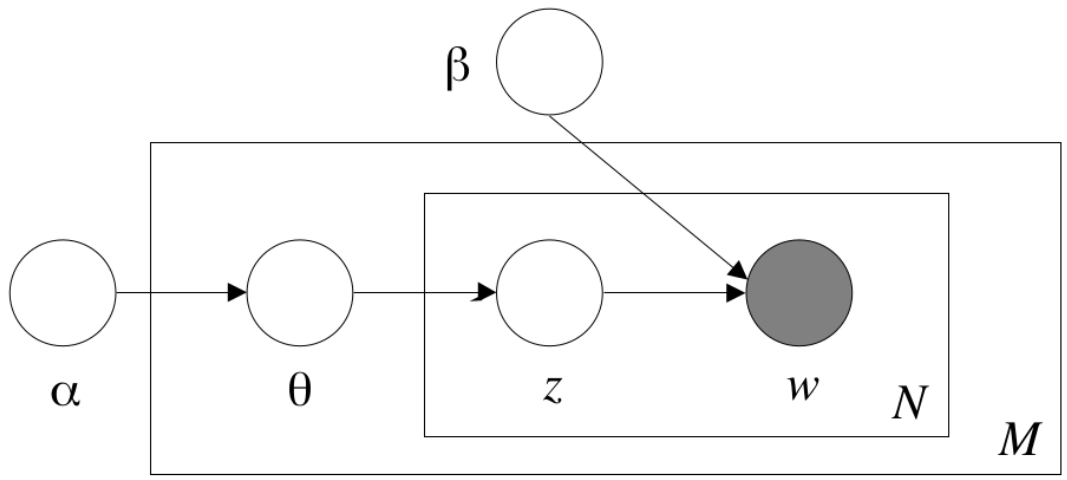
<figcaption>Figure 1: Latent Dirichlet Allocation in ``Plate Model’’
notation (source: Blei et al, 2003)</figcaption>
</figure>

Figure <a href="#fig-lda" class="quarto-xref">1</a> is a more formal
notation of the same generative model. Starting from the left, for each
document you pick a set of topics $\Theta$. This set of topics is drawn
from a *Dirichlet distribution* which itself has a parameter $\alpha$
(see note). Next, for each word you select a single topic $z$ from the
topics in that document. Finally, you pick an actual word $w$ from the
words in that topic, again controlled by a parameter $\beta$.

Now, if we know which words and documents are in which topics, we can
start generating the documents in the corpus. In reality, of course, we
have the reverse situation: we know the documents, and we want to know
the topics. Thus, the task of LDA is to find the parameters that have
the highest chance of generating these documents. Since only the word
frequencies are observed, this is a latent variable model where we want
to find the most likely values for the (latent) topic $z$ for each word
in each document.

Unfortunately, there is no simple analytic solution to calculate these
topic assignments like there is for OLS regression. Thus, like other
more complicated statistical models such as multilevel regression, we
need to use an iterative estimation that progressively optimizes the
assignment to improve the fit until it converges.

An estimation method that is often used for LDA is Gibbs sampling.
Simply put, this starts with a random assignment of topics to words.
Then, in each iteration, it reconsiders each word and recomputes what
likely topics for that word are given the other topics in that document
and the topics in which that word occurs in other documents. Thus, if a
document already contains a number of words placed in a certain topic, a
new word is more likely to be placed in that topic as well. After enough
iterations, this converges to a solution.

> **The Dirichlet Distribution and its Hyperparameters**
>
> The Dirichlet distribution can be seen as a distribution over
> multinomial distributions, that is, every draw from a Dirichlet
> distribution results in a multinomial distribution. An easy way to
> visualize this is to see the Dirichlet distribution as a bag of dice.
> You draw a die from the bag, and each die is a distribution over the
> numbers one to six.
>
> This distribution is controlled by a parameter called alpha
> ($\alpha$), which is often called a *hyperparameter* because it is a
> parameter that controls how other parameters (the actual topic
> distributions) are estimated, similar to, e.g., the learning speed in
> many machine learning models. This alpha hyperparameter controls what
> kind of dice there are in the bag. A high alpha means that the dice
> are generally fair, i.e., give a uniform multinomial distribution. For
> topic models, this means that documents will in general contain an
> even spread of multiple topics. A low alpha means that each die is
> unfair in the sense of having a strong preference for some number(s),
> as if these numbers are weighted. You can then draw a die that prefers
> ones, or a die that prefers sixes. For topic models this means that
> each document tends to have one or two dominant topics. Finally, alpha
> can be symmetric (meaning dice are unfair, but randomly, so in the end
> each topic has the same chance) or asymmetric (they are still unfair,
> and now also favor some topics more than others). This would
> correspond to some topics being more likely to occur in all documents.
>
> In our experience, most documents actually do have one or two dominant
> topics, and some topics are actually more prevalent across many
> documents then others – especially if you consider that procedural
> words and boilerplate also need to be fit into a topic unless they are
> filtered out beforehand. Thus, we would generally recommend a
> relatively low and asymmetric alpha, and in fact *gensim* provides an
> algorithm to find, based on the data, an alpha that corresponds to
> this recommendation (by specifying `alpha='auto'`). In R, we would
> recommend picking a lower alpha than the default value, probably
> around $\alpha=5/K$, and optionally try using an asymmetric alpha if
> you find some words that occur across multiple topics.
>
> To get a more intuitive understanding of the effects of alpha, please
> see [cssbook.net/lda](https://cssbook.net/lda) for additional material
> and visualizations.

### Fitting an LDA Model

> **Note**
>
> <span class="theorem-title">**Example 14**</span> LDA Topic Model of
> Obama’s State of the Union speeches.
>
> ## Python code
>
> ``` python
> url = "https://cssbook.net/d/sotu.csv"
> sotu = pd.read_csv(url)
> p_obama = sotu[sotu.President == "Obama"].text.str.split("\n\n").explode()
>
> cv = CountVectorizer(min_df=0.01, stop_words="english")
> dtm = cv.fit_transform(p_obama)
> dtm
> corpus = matutils.Sparse2Corpus(dtm, documents_columns=False)
> vocab = dict(enumerate(cv.get_feature_names_out()))
> lda = LdaModel(
>     corpus, id2word=vocab, num_topics=10, random_state=123, alpha="asymmetric"
> )
> ```
>
> ``` python
> pd.DataFrame(
>     {
>         f"Topic {n}": [w for (w, tw) in words]
>         for (n, words) in lda.show_topics(formatted=False)
>     }
> )
> ```
>
> ## R code

Example <a href="#exm-lda" class="quarto-xref">14</a> shows how you can
fit an LDA model in Python or R. As example data, we use Obama’s State
of the Union Speeches using the corpus introduced in Chapter
**?@sec-chap-dtm**. Since such a speech generally touches on many
different topics, we choose to first split by paragraph as these will be
more semantically coherent (for Obama, at least). In R, we use the
`corpus_reshape` function to split the paragraphs, while in Python we
use *pandas*’ `str.split`, which creates a list or paragraphs for each
text, which we then convert into a paragraph per row using `explode`.
Converting this to a DTM we get a reasonably sized matrix of 738
paragraphs and 746 unique words.

Next, we fit the actual LDA model using the package *gensim* (Python)
and *topicmodels* (R). Before we can do this, we need to convert the DTM
format into a format accepted by that package. For Python, this is done
using the `Sparse2Corpus` helper function while in R this is done with
the *quanteda* `convert` function. Then, we fit the model, asking for 10
topics to be identified in these paragraphs. There are three things to
note in this line. First, we specify a *random seed* of 123 to make sure
the analysis is replicable. Second, we specify an “asymmetric” of
`1/1:10`, meaning the first topic has alpha 1, the second 0.5, etc. (in
R). In Python, instead of using the default of `alpha='symmetric'`, we
set `alpha='asymmetric'`, which uses the formula
$\frac{1}{topic\_index + \sqrt{num\_topics}}$ to determine the priors.
At the cost of a longer estimation time, we can even specify
`alpha='auto'`, which will learn an asymmetric prior from the data. See
the note on hyperparameters for more information. Third, for Python we
also need to specify the vocabulary names since these are not included
in the DTM.

The final line generates a data frame of top words per topic for first
inspection (which in Python requires separating the words from their
weights in a list comprehension and converting it to a data frame for
easy viewing). As you can see, most topics are interpretable and
somewhat coherent: for example, topic 1 seems to be about education and
jobs, while topic 2 is health care. You also see that the word “job”
occurs in multiple topics (presumably because unemployment was a
pervasive concern during Obama’s tenure). Also, some topics like topic 3
are relatively more difficult to interpret from this table. A possible
reason for this is that not every paragraph actually has policy content.
For example, the first paragraph of his first State of the Union was:
*Madam Speaker, Mr. Vice President, Members of Congress, the First Lady
of the United States – she’s around here somewhere*. None of these words
really fit a “topic” in the normal meaning of that term, but all of
these words need to be assigned a topic in LDA. Thus, you often see
“procedural” or “boilerplate” topics such as topic 3 occurring in LDA
outputs.

Finally, note that we showed the R results here. As *gensim* uses a
different estimation algorithm (and <code>scikit-learn</code>uses a
different tokenizer and stopword list), results will not be identical,
but should be mostly similar.

### Analyzing Topic Model Results

> **Note**
>
> <span class="theorem-title">**Example 15**</span> Analyzing and
> inspecting LDA results.
>
> ## Python code
>
> ``` python
> topics = pd.DataFrame(
>     [
>         dict(lda.get_document_topics(doc, minimum_probability=0.0))
>         for doc in corpus
>     ]
> )
> meta = sotu.iloc[p_obama.index].drop(columns=["text"]).reset_index(drop=True)
> tpd = pd.concat([meta, topics], axis=1)
> tpd.head()
> for docid in [622, 11, 322]:
>     print(f"{docid}: {list(p_obama)[docid]}")
> ```
>
> ## R code

Example <a href="#exm-ldaresults" class="quarto-xref">15</a> shows how
you can combine the LDA results (topics per document) with the original
document metadata. This could be your starting point for substantive
analyses of the results, for example to investigate relations between
topics or between, e.g., time or partisanship and topic use.

You can also use this to find specific documents for reading. For
example, we noted above that topic 3 is difficult to interpret. As you
can see in the table in Example
<a href="#exm-ldaresults" class="quarto-xref">15</a> (which is sorted by
value of topic 3), most of the high scoring documents are the first
paragraph in each speech, which do indeed contain the “Madam speaker”
boilerplate noted above. The other three documents are all calls for
bipartisanship and support. As you can see from this example, carefully
inspecting the top documents for each topic is very helpful for making
sense of the results.

### Validating and Inspecting Topic Models

As we saw in the previous subsection, running a topic model is
relatively easy. However, that doesn’t mean that the resulting topic
model will always be useful. As with all text analysis techniques,
*validation* is the key to good analysis: are you measuring what you
want to measure? And how do you know?

For topic modeling (and arguably for all text analysis), the first step
after fitting a model is inspecting the results and establishing face
validity. Top words per topic such as those listed above are a good
place to start, but we would really encourage you to also look at the
top documents per topic to better understand how words are used in
context. Also, it is good to inspect the relationships between topics
and look at documents that load high on multiple topics to understand
the relationship.

If the only goal is to get an explorative understanding of the corpus,
for example as a first step before doing a dictionary analysis or manual
coding, just face validity is probably sufficient. For a more formal
validation, however, it depends on the reason for using topic modeling.

If you are using topic modeling in a true unsupervised sense, i.e.,
without a predefined analytic schema in mind, it is difficult to assess
whether the model measures what you want to measure – because the whole
point is that you don’t know what you want to measure. That said,
however, you can have the general criteria that the model needs to
achieve *coherence* and *interpretability*, meaning that words and
documents that share a topic are also similar semantically.

In their excellent paper on the topic, @chang09 propose two formal tasks
to judge this using manual (or crowd) coding: in *word intrusion*, a
coder is asked to pick the “odd one out” from a list where one other
word is mixed in a group of topic words. In *topic intrusion*, the coder
is presented with a document and a set of topics that occur in the
document, and is asked to spot the one topic that was not present
according to the model. In both tasks, if the coder is unable to
identify the intruding word or topic, apparently the model does not fit
our intuitive notion of “aboutness” or semantic similarity. Perhaps
their most interesting finding is that goodness-of-fit measures like
perplexity[1] are actually not good predictors of the interpretability
of the resulting models.

If you are using topic models in a more confirmatory manner, that is, if
you wish the topics to match some sort of predefined categorization, you
should use regular gold standard techniques for validation: code a
sufficiently large random sample of documents with your predefined
categories, and test whether the LDA topics match those categories. In
general, however, in such cases it is a better idea to use a dictionary
or supervised analysis technique as topic models often do not exactly
capture our categories. After all, unsupervised techniques mainly excel
in bottom-up and explorative analyses (Section
<a href="#sec-deciding" class="quarto-xref">1.1</a>).

### Beyond LDA

This chapter focused on regular or “vanilla” LDA topic modeling. Since
the seminal publication, however, a large amount of variations and
extensions on LDA have been proposed. These include, for example,
*Dynamic Topic Models* (which incorporate time; @dynamiclda) and
*Correlated Topic Models* (which explicitly model correlation between
topics; @correlatedlda). Although it is beyond the scope of this book to
describe these models in detail, the interested reader is encouraged to
learn more about these models.

Especially noteworthy are *Structural Topic Models* (R package *stm*;
@stm), which allow you to model covariates as topic or word predictors.
This allows you, for example, to model topic shifts over time or
different words for the same topic based on, e.g., Republican or
Democrat presidents.

Python users should check out *Hierarchical Topic Modeling*
\[@hierarchicallda\]. In hierarchical topic modeling, rather than the
researcher specifying a fixed number of topics, the model returns a
hierarchy of topics from few general topics to a large number of
specific topics, allowing for a more flexible exploration and analysis
of the data.

> **How many topics?**
>
> With topic modeling, the most important researcher choices are the
> *number of topics* and the value of *alpha*. These choices are called
> *hyperparameters*, since they determine how the model parameters
> (e.g. words per topic) are found.
>
> There is no good theoretical solution to determine the “right” number
> of topics for a given corpus and research question. Thus, a sensible
> approach can be to ask the computer to try many models, and see which
> works best. Unfortunately, because this is an unsupervised (inductive)
> method, there is no single metric that determines how good a topic
> model is.
>
> There are a number of such metrics proposed in the literature, of
> which we will introduce two. *Perplexity* is a score of how well the
> LDA model can fit (predict) the actual word distribution (or in other
> words: how “perplexed” the model is seeing the corpus). *Coherence* is
> a measure of how semantically coherent the topics are by checking how
> often the top token co-occurs in documents in each topic \[@mimno11\].
>
> The code below shows how these can be calculated for a range of topic
> counts, and the same code could be used for trying different values of
> *alpha*. For both measures, lower values are better, and both
> essentially keep decreasing as you add more topics. What you are
> looking for is the *inflection point* (or “elbow point”) where it goes
> from a steep decrease to a more gradual decrease. For coherence, this
> seems to be at 10 topics, while for perplexity this is at 20 topics.
>
> There are two very important caveats to make here, however. First,
> these metrics are no substitute for human validation and the best
> model according to these metrics is not always the most interpretable
> or coherent model. In our experience, most metrics give a higher topic
> count that would be optimal from an interpretability perspective, but
> of course that also depends on how we operationalize interpretability.
> Nonetheless, these topic numbers are probably more indicative of a
> range of counts that should be inspected manually, rather than giving
> a definitive answer.
>
> Second, the code below was written so it is easy to understand and
> quick to run. For real use in a research project, it is advised to
> include a broader range of topic counts and also vary the $\alpha$.
> Moreover, it is smart to run each count multiple times so you get an
> indication of the variance as well as a single point (it is quite
> likely that the local minimum for coherence at $k=10$ is an outlier
> that will disappear if more runs are averaged). Finally, especially
> for a goodness-of-fit measure like perplexity it is better to split
> the data into a training and test set (see Section
> <a href="#sec-workflow" class="quarto-xref">1.4.1</a> for more
> details).
>
> ## Python code
>
> ``` python
> result = []
> for k in [5, 10, 15, 20, 25, 30]:
>     m = LdaModel(
>         corpus,
>         num_topics=k,
>         id2word=vocab,
>         random_state=123,
>         alpha="asymmetric",
>     )
>     perplexity = m.log_perplexity(corpus)
>     coherence = CoherenceModel(
>         model=m, corpus=corpus, coherence="u_mass"
>     ).get_coherence()
>     result.append(dict(k=k, perplexity=perplexity, coherence=coherence))
>
> result = pd.DataFrame(result)
> result.plot(x="k", y=["perplexity", "coherence"])
> plt.show()
> ```
>
> ## R code

[1] Perplexity is a measure to compare and evaluate topic models using
log-likelihood in order to estimate how well a model predicts a sample.
See the note ‘how many topics’ below for example code on how to compute
perplexity